In [57]:
#Import databases and dependencies
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
import numpy as np
import numpy_financial as npf
import alpaca_trade_api as tradeapi
import requests
import json
import cryptowatch as cw
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from pathlib import Path
from dotenv import load_dotenv
from pycoingecko import CoinGeckoAPI
from datetime import datetime, timedelta
from MCForecastTools import MCSimulation
%matplotlib inline

In [58]:
# Load .env enviroment variables
load_dotenv()

True

In [59]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [60]:
# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [61]:
# Set date
start_date = pd.Timestamp("2006-07-01", tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-01-01', tz='America/New_York').isoformat()

# Tickers for an all-weather set and forget portfolio 
tickers = ["SPY", "TLT", "IEF", "GLD", "DJP"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# 10 years of data
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df


C:\Users\Admin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:18: DeprecatedWarning:

get_barset is deprecated as of v1.0.0. Use get_bars instead



In [62]:
df_stock_data.head()

DJP                                      GLD  \
                            open    high     low  close    volume    open   
time                                                                        
2018-01-11 00:00:00-05:00  24.55  24.610  24.500  24.51  278556.0     NaN   
2018-01-12 00:00:00-05:00  24.58  24.720  24.530  24.72  304649.0  126.01   
2018-01-16 00:00:00-05:00  24.55  24.606  24.490  24.57  443871.0  126.60   
2018-01-17 00:00:00-05:00  24.60  24.715  24.560  24.67  627270.0  126.77   
2018-01-18 00:00:00-05:00  24.65  24.700  24.545  24.64  280475.0  126.13   

                                                               ...     SPY  \
                             high     low    close     volume  ...    open   
time                                                           ...           
2018-01-11 00:00:00-05:00     NaN     NaN      NaN        NaN  ...     NaN   
2018-01-12 00:00:00-05:00  127.13  125.81  126.975  7474319.0  ...  276.42   
2018-01-16 00:00:00-05:00  127.18  126.40  127.170  6614262.0  ...  279.35   
2018-01-17 00:00:00-05:00  127.22  125.90  126.140  8772608.0  ...  278.04   
2018-01-18 00:00:00-05:00  126.52  125.80  125.850  5280076.0  ...  279.50   

                                                                  TLT          \
                             high     low   close      volume    open    high   
time                                                                            
2018-01-11 00:00:00-05:00     NaN     NaN     NaN         NaN     NaN     NaN   
2018-01-12 00:00:00-05:00  278.11  276.27  277.91  53855427.0  124.10  124.79   
2018-01-16 00:00:00-05:00  280.09  276.18  276.96  70240852.0  125.17  125.28   
2018-01-17 00:00:00-05:00  280.05  277.19  279.61  62162956.0  125.08  125.64   
2018-01-18 00:00:00-05:00  279.96  278.58  279.18  57402163.0  123.93  124.27   

                                                       
                               low   close     volume  
time                                                   
2018-01-11 00:00:00-05:00      NaN     NaN        NaN  
2018-01-12 00:00:00-05:00  123.910  124.53  7709191.0  
2018-01-16 00:00:00-05:00  124.560  125.03  7865423.0  
2018-01-17 00:00:00-05:00  124.595  124.89  6865138.0  
2018-01-18 00:00:00-05:00  123.535  123.73  9307990.0  

[5 rows x 25 columns]

In [63]:
df_stock_data.xs('close',level=1,axis=1)

,DJP,GLD,IEF,SPY,TLT
time,,,,,
2018-01-11 00:00:00-05:00,24.51,NaN,NaN,NaN,NaN
2018-01-12 00:00:00-05:00,24.72,126.975,104.56,277.91,124.53
2018-01-16 00:00:00-05:00,24.57,127.170,104.61,276.96,125.03
2018-01-17 00:00:00-05:00,24.67,126.140,104.39,279.61,124.89
2018-01-18 00:00:00-05:00,24.64,125.850,104.05,279.18,123.73
...,...,...,...,...,...
2021-12-27 00:00:00-05:00,29.13,169.370,115.35,477.27,148.86
2021-12-28 00:00:00-05:00,28.98,168.655,115.33,476.89,148.28
2021-12-29 00:00:00-05:00,29.05,168.590,114.77,477.46,146.66


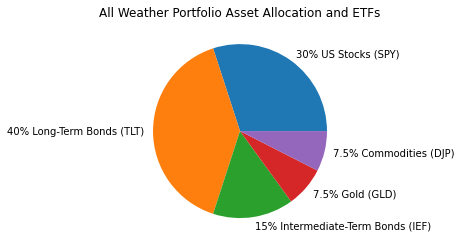

In [64]:
#visualise portfolio allocation
import matplotlib.pyplot as plt

y = np.array([30, 40, 15, 7.5, 7.5])
mylabels = ["30% US Stocks (SPY)", "40% Long-Term Bonds (TLT)", "15% Intermediate-Term Bonds (IEF)", "7.5% Gold (GLD)", "7.5% Commodities (DJP)"]
plt.pie(y, labels = mylabels)
plt.title("All Weather Portfolio Asset Allocation and ETFs")
plt.show() 

In [65]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.3, .4, .15, .075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*10
)
# Printing the simulation input data
MC_even_dist.portfolio_data.head(-10)

DJP                                      \
                            open     high      low  close     volume   
time                                                                   
2018-01-11 00:00:00-05:00  24.55  24.6100  24.5000  24.51   278556.0   
2018-01-12 00:00:00-05:00  24.58  24.7200  24.5300  24.72   304649.0   
2018-01-16 00:00:00-05:00  24.55  24.6060  24.4900  24.57   443871.0   
2018-01-17 00:00:00-05:00  24.60  24.7150  24.5600  24.67   627270.0   
2018-01-18 00:00:00-05:00  24.65  24.7000  24.5450  24.64   280475.0   
...                          ...      ...      ...    ...        ...   
2021-12-10 00:00:00-05:00  27.90  27.9600  27.7900  27.92  1035421.0   
2021-12-13 00:00:00-05:00  28.03  28.0800  27.8001  27.83    87574.0   
2021-12-14 00:00:00-05:00  27.60  27.6595  27.5155  27.61   685666.0   
2021-12-15 00:00:00-05:00  27.54  27.7300  27.3500  27.71   651419.0   
2021-12-16 00:00:00-05:00  27.84  28.1221  27.8200  27.97   592798.0   

                                           GLD                            ...  \
                          daily_return    open     high     low    close  ...   
time                                                                      ...   
2018-01-11 00:00:00-05:00          NaN     NaN      NaN     NaN      NaN  ...   
2018-01-12 00:00:00-05:00     0.008568  126.01  127.130  125.81  126.975  ...   
2018-01-16 00:00:00-05:00    -0.006068  126.60  127.180  126.40  127.170  ...   
2018-01-17 00:00:00-05:00     0.004070  126.77  127.220  125.90  126.140  ...   
2018-01-18 00:00:00-05:00    -0.001216  126.13  126.520  125.80  125.850  ...   
...                                ...     ...      ...     ...      ...  ...   
2021-12-10 00:00:00-05:00     0.006852  166.72  166.915  166.18  166.590  ...   
2021-12-13 00:00:00-05:00    -0.003223  166.90  167.255  166.67  167.035  ...   
2021-12-14 00:00:00-05:00    -0.007905  165.34  166.140  165.16  165.450  ...   
2021-12-15 00:00:00-05:00     0.003622  165.29  166.400  163.80  166.150  ...   
2021-12-16 00:00:00-05:00     0.009383  167.01  168.180  166.94  168.170  ...   

                              SPY                                         TLT  \
                              low   close       volume daily_return      open   
time                                                                            
2018-01-11 00:00:00-05:00     NaN     NaN          NaN          NaN       NaN   
2018-01-12 00:00:00-05:00  276.27  277.91   53855427.0          NaN  124.1000   
2018-01-16 00:00:00-05:00  276.18  276.96   70240852.0    -0.003418  125.1700   
2018-01-17 00:00:00-05:00  277.19  279.61   62162956.0     0.009568  125.0800   
2018-01-18 00:00:00-05:00  278.58  279.18   57402163.0    -0.001538  123.9300   
...                           ...     ...          ...          ...       ...   
2021-12-10 00:00:00-05:00  466.51  470.72   64958435.0     0.009392  149.9200   
2021-12-13 00:00:00-05:00  466.27  466.61   53533452.0    -0.008731  150.4000   
2021-12-14 00:00:00-05:00  460.25  463.39   84376354.0    -0.006901  150.3500   
2021-12-15 00:00:00-05:00  460.74  470.58   97945190.0     0.015516  149.6139   
2021-12-16 00:00:00-05:00  464.80  466.43  100111230.0    -0.008819  148.7500   

                                                                               
                              high      low    close      volume daily_return  
time                                                                           
2018-01-11 00:00:00-05:00      NaN      NaN      NaN         NaN          NaN  
2018-01-12 00:00:00-05:00  124.790  123.910  124.530   7709191.0          NaN  
2018-01-16 00:00:00-05:00  125.280  124.560  125.030   7865423.0     0.004015  
2018-01-17 00:00:00-05:00  125.640  124.595  124.890   6865138.0    -0.001120  
2018-01-18 00:00:00-05:00  124.270  123.535  123.730   9307990.0    -0.009288  
...                            ...      ...      ...         ...          ...  
2021-12-10 00:00:00-05:00  150

In [66]:
dat = pd.DataFrame(MC_even_dist.portfolio_data)
dat.head()

DJP                                   \
                            open    high     low  close    volume   
time                                                                
2018-01-11 00:00:00-05:00  24.55  24.610  24.500  24.51  278556.0   
2018-01-12 00:00:00-05:00  24.58  24.720  24.530  24.72  304649.0   
2018-01-16 00:00:00-05:00  24.55  24.606  24.490  24.57  443871.0   
2018-01-17 00:00:00-05:00  24.60  24.715  24.560  24.67  627270.0   
2018-01-18 00:00:00-05:00  24.65  24.700  24.545  24.64  280475.0   

                                           GLD                           ...  \
                          daily_return    open    high     low    close  ...   
time                                                                     ...   
2018-01-11 00:00:00-05:00          NaN     NaN     NaN     NaN      NaN  ...   
2018-01-12 00:00:00-05:00     0.008568  126.01  127.13  125.81  126.975  ...   
2018-01-16 00:00:00-05:00    -0.006068  126.60  127.18  126.40  127.170  ...   
2018-01-17 00:00:00-05:00     0.004070  126.77  127.22  125.90  126.140  ...   
2018-01-18 00:00:00-05:00    -0.001216  126.13  126.52  125.80  125.850  ...   

                              SPY                                      TLT  \
                              low   close      volume daily_return    open   
time                                                                         
2018-01-11 00:00:00-05:00     NaN     NaN         NaN          NaN     NaN   
2018-01-12 00:00:00-05:00  276.27  277.91  53855427.0          NaN  124.10   
2018-01-16 00:00:00-05:00  276.18  276.96  70240852.0    -0.003418  125.17   
2018-01-17 00:00:00-05:00  277.19  279.61  62162956.0     0.009568  125.08   
2018-01-18 00:00:00-05:00  278.58  279.18  57402163.0    -0.001538  123.93   

                                                                            
                             high      low   close     volume daily_return  
time                                                                        
2018-01-11 00:00:00-05:00     NaN      NaN     NaN        NaN          NaN  
2018-01-12 00:00:00-05:00  124.79  123.910  124.53  7709191.0          NaN  
2018-01-16 00:00:00-05:00  125.28  124.560  125.03  7865423.0     0.004015  
2018-01-17 00:00:00-05:00  125.64  124.595  124.89  6865138.0    -0.001120  
2018-01-18 00:00:00-05:00  124.27  123.535  123.73  9307990.0    -0.009288  

[5 rows x 30 columns]

In [67]:
dat.xs('daily_return',level=1,axis=1)

,DJP,GLD,IEF,SPY,TLT
time,,,,,
2018-01-11 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN
2018-01-12 00:00:00-05:00,0.008568,NaN,NaN,NaN,NaN
2018-01-16 00:00:00-05:00,-0.006068,0.001536,0.000478,-0.003418,0.004015
2018-01-17 00:00:00-05:00,0.004070,-0.008099,-0.002103,0.009568,-0.001120
2018-01-18 00:00:00-05:00,-0.001216,-0.002299,-0.003257,-0.001538,-0.009288
...,...,...,...,...,...
2021-12-27 00:00:00-05:00,0.018888,0.002189,0.000347,0.014216,0.002424
2021-12-28 00:00:00-05:00,-0.005149,-0.004222,-0.000173,-0.000796,-0.003896
2021-12-29 00:00:00-05:00,0.002415,-0.000385,-0.004856,0.001195,-0.010925


In [68]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Admin\Desktop\group_project_1\MCForecastTools.py:117: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997107,1.002460,1.000567,0.998037,0.999102,0.997237,0.992685,0.997494,1.008510,1.000950,...,1.000253,1.003144,1.005940,0.993862,1.002158,0.993799,1.006643,0.995679,1.006461,1.001630
2,0.998501,1.001542,1.003956,0.998987,0.998355,0.991671,0.988263,0.995248,1.007420,1.005254,...,0.997173,1.005882,1.006552,1.001585,1.006174,0.995796,1.013178,1.003532,1.003359,0.992925
3,1.006100,1.002142,0.998564,0.999370,1.007593,0.986223,0.990438,0.995016,1.004016,1.006318,...,0.999066,1.004604,1.010690,1.007078,0.999181,0.997492,1.010834,1.002678,1.009181,0.998478
4,1.005260,1.006948,0.996634,0.998035,1.000772,0.984627,0.985474,0.987835,1.011661,1.003900,...,0.992404,1.003586,1.017947,1.005209,0.997049,1.001575,1.019770,1.003973,1.002043,0.991420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.265956,2.098866,2.416157,1.514476,2.449409,2.397786,2.096680,2.015998,1.767881,1.644096,...,1.582181,2.154729,1.713052,1.703993,1.828844,2.372145,1.918754,1.959215,1.633376,1.680852
2517,2.278388,2.090738,2.413427,1.502802,2.451959,2.392687,2.101686,2.018931,1.768972,1.639585,...,1.579408,2.151840,1.701897,1.698170,1.821048,2.373484,1.910408,1.958492,1.623570,1.674702
2518,2.267434,2.076872,2.425129,1.503933,2.448820,2.411318,2.108006,2.023122,1.763351,1.635613,...,1.588039,2.161966,1.712400,1.692401,1.832707,2.375193,1.913351,1.962709,1.629810,1.682429
2519,2.272842,2.079054,2.425321,1.507374,2.459521,2.443886,2.119385,2.039756,1.772355,1.634180,...,1.584319,2.162497,1.704849,1.701041,1.836256,2.379231,1.932469,1.968798,1.632020,1.685137


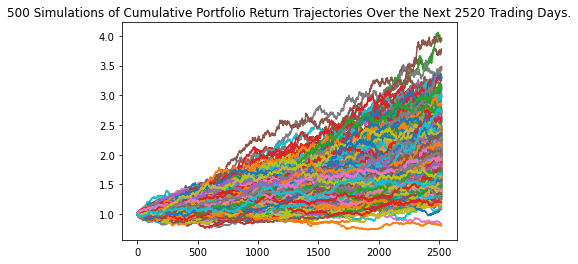

In [69]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

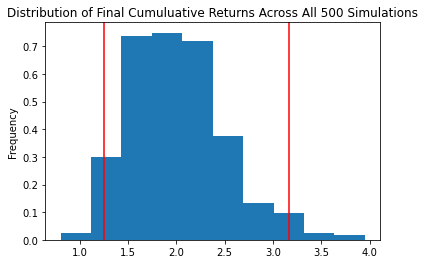

In [70]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

In [71]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           500.000000
mean              2.005757
std               0.497437
min               0.802930
25%               1.640052
50%               1.964978
75%               2.298235
max               3.951573
95% CI Lower      1.252988
95% CI Upper      3.167862
Name: 2520, dtype: float64


In [72]:
# Set initial investment
initial_investment = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $100,000
ci_lower = round(even_tbl[8]*initial_investment,2)
ci_upper = round(even_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 10 years will end within in the range of $125298.8 and $316786.23


In [73]:
#Calculate cumulative returns for portfolio
cum_returns = MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Admin\Desktop\group_project_1\MCForecastTools.py:117: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

In [74]:
# Reverse cumulative return function for further calculations
def reverse_cum_return(df):
    return (1 + df) / (1 + df.shift(1)) - 1

In [75]:
#Sharpe Ratio forecast
simulation_returns = cum_returns.apply(reverse_cum_return, axis = 0)
simulation_returns.dropna(inplace = True)
simulation_returns.isna().sum().sum()

0

In [76]:
mean_expectation_simulations = simulation_returns.mean(axis = 1)
mean_expectation_simulations

1       0.000117
2       0.000012
3       0.000153
4       0.000070
5       0.000097
          ...   
2516    0.000001
2517   -0.000039
2518    0.000027
2519    0.000227
2520    0.000042
Length: 2520, dtype: float64

In [77]:
# Annual Sharpe Ratio
mean_expectation_simulations.mean() * 252 /(mean_expectation_simulations.std() * (252**0.5))

19.799894945180622

In [78]:
mean_expectation_simulations.std() * np.sqrt(252)
mean_expectation_simulations.mean() *252

0.04031397372365878

In [79]:
# Expected volatility for every day change
std_expectation_simu = simulation_returns.std(axis = 1) 

<AxesSubplot:>

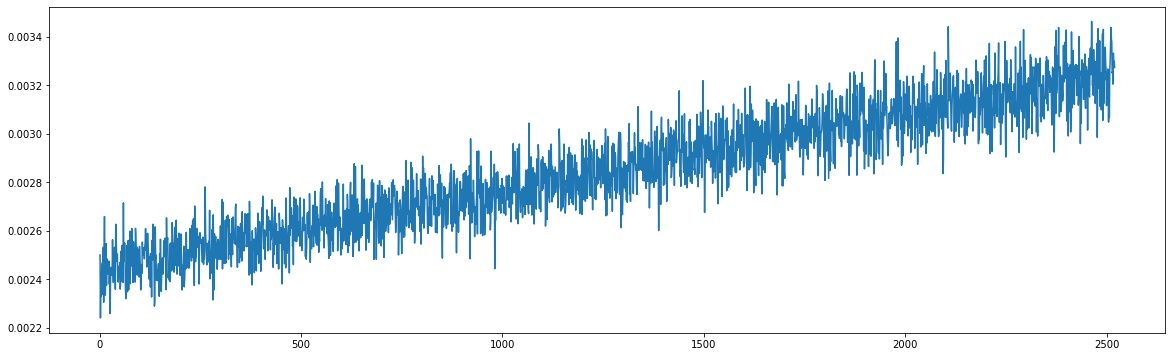

In [80]:
# Expected change for every simulation for every day in our returns (how much our rerun forecasts are changing every day based on the simulation of random numbers)
std_expectation_simu.plot(figsize = (20,6)) 

<AxesSubplot:>

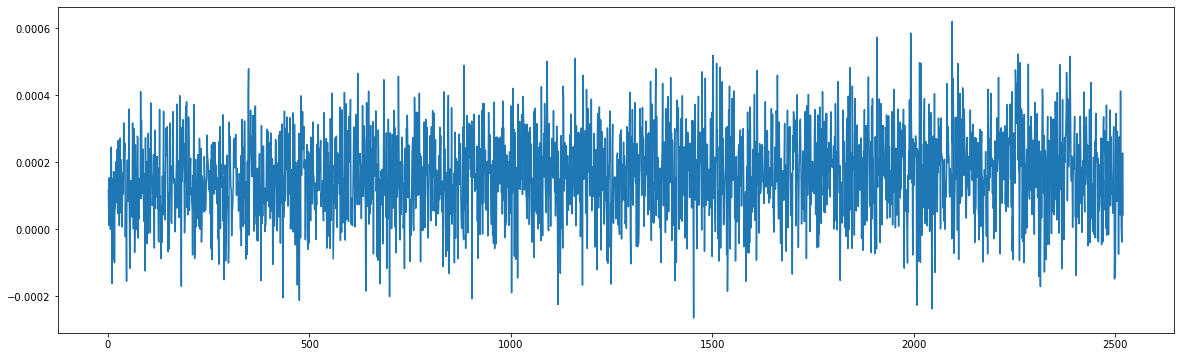

In [81]:
mean_expectation_simulations.plot(figsize = (20,6))

<AxesSubplot:>

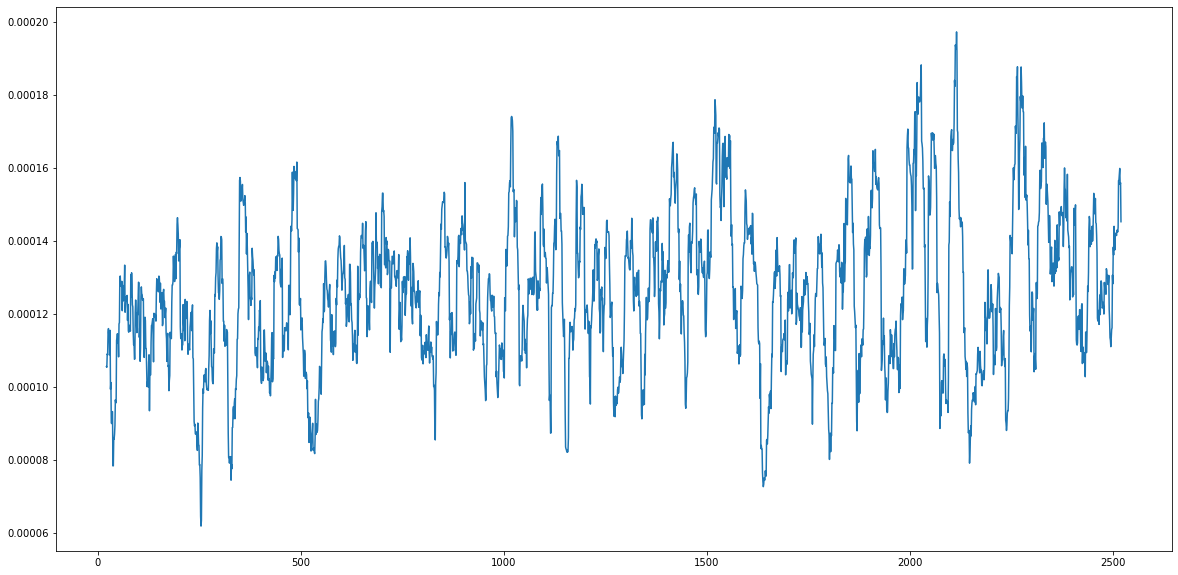

In [82]:
# Volatility of the expected simulation returns 
mean_expectation_simulations.rolling(21).std().plot(figsize = (20,10))

In [83]:
#Gaetano Yahoo Finance Portfolio

In [84]:
#creating variables for the tickers to use yfinance API functions
btc = yf.Ticker("BTC-USD")
eth = yf.Ticker("ETH-USD")
xrp = yf.Ticker("XRP-USD")
ada = yf.Ticker("ADA-USD")
link = yf.Ticker("LINK-USD")
doge = yf.Ticker("DOGE-USD")
ixic = yf.Ticker("^IXIC")
gspc = yf.Ticker("^GSPC")
axjo = yf.Ticker("^AXJO")

In [85]:
#creating functions that retrive specific data from API

def twoHundredDayAverage(tick):
    result = tick.info["twoHundredDayAverage"]
    return (f"200 Days Average Price is: ${result}")

def todayOpen(tick):
    result = tick.info["open"]
    return (f"Today open price is: ${result}")

def Volume(tick):
    result = tick.info["volume"]
    return (f"Today volume is: ${result}")

def marketCap(tick):
    result = tick.info["marketCap"]
    return (f"Market capitalization is: ${result}")

print(twoHundredDayAverage(eth))
print(todayOpen (eth))
print(Volume (eth))
print(marketCap (eth))

200 Days Average Price is: $3578.647
Today open price is: $2783.1042
Today volume is: $15394084864
Market capitalization is: $337074585600


In [86]:
#importing data with yfinance API
crypto_df = yf.download("BTC-USD ETH-USD XRP-USD ADA-USD DOGE-USD LINK-USD USDT-USD BNB-USD" , start="2017-01-01", end= "2022-01-01")
index_df = yf.download("^IXIC ^GSPC ^AXJO", start="2017-01-01", end= "2022-01-01")

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  3 of 3 completed


In [87]:
#calculate % change on close prices
crypto_daily_change = crypto_df["Close"].pct_change().dropna()
index_daily_change = index_df["Close"].pct_change().dropna()
crypto_daily_change.head()

,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,USDT-USD,XRP-USD
Date,,,,,,,,
2017-11-10,-0.153933,-0.097415,-0.073554,-0.178092,-0.067411,-0.162375,-0.002152,-0.050600
2017-11-11,0.011726,-0.070329,-0.039368,0.032674,0.051555,-0.041748,0.002962,0.019115
2017-11-12,-0.126107,-0.090262,-0.064101,-0.135720,-0.021523,-0.049352,0.003449,-0.062211
2017-11-13,0.076365,0.109845,0.102422,0.166667,0.028606,0.071230,-0.003082,0.030927
2017-11-14,0.016352,-0.055757,0.011626,-0.022296,0.066037,0.027547,-0.002497,0.031375


In [88]:
index_daily_change.head()

,^AXJO,^GSPC,^IXIC
Date,,,
2017-01-04,0.000558,0.005722,0.008827
2017-01-05,0.002946,-0.000771,0.001997
2017-01-06,0.000400,0.003517,0.006035
2017-01-09,0.009000,-0.003549,0.001949
2017-01-10,-0.008041,0.000000,0.003615


In [89]:
#concat dataframes
combined_df = pd.concat([crypto_daily_change, index_daily_change], axis="columns", join="inner")

combined_df

,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,USDT-USD,XRP-USD,^AXJO,^GSPC,^IXIC
Date,,,,,,,,,,,
2017-11-10,-0.153933,-0.097415,-0.073554,-0.178092,-0.067411,-0.162375,-0.002152,-0.050600,-0.003306,-0.000898,0.000132
2017-11-13,0.076365,0.109845,0.102422,0.166667,0.028606,0.071230,-0.003082,0.030927,-0.001261,0.000984,0.000987
2017-11-14,0.016352,-0.055757,0.011626,-0.022296,0.066037,0.027547,-0.002497,0.031375,-0.009266,-0.002310,-0.002920
2017-11-15,0.008197,-0.039012,0.102444,0.130912,-0.012659,-0.010504,-0.003625,0.014922,-0.005330,-0.005526,-0.004699
2017-11-16,0.042919,0.031017,0.076023,0.038088,-0.007298,-0.087983,-0.001057,0.066450,0.001567,0.008196,0.012985
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.039056,0.028604,-0.003328,-0.012183,-0.007322,-0.001203,-0.000505,0.005432,0.000000,0.013839,0.013920
2021-12-28,-0.073136,-0.049256,-0.060259,-0.072390,-0.058613,-0.112722,0.001224,-0.079060,0.000000,-0.001010,-0.005642
2021-12-29,-0.050953,-0.039122,-0.024042,-0.036481,-0.045348,-0.033769,-0.000873,-0.042494,0.012062,0.001402,-0.000982


<AxesSubplot:xlabel='Date'>

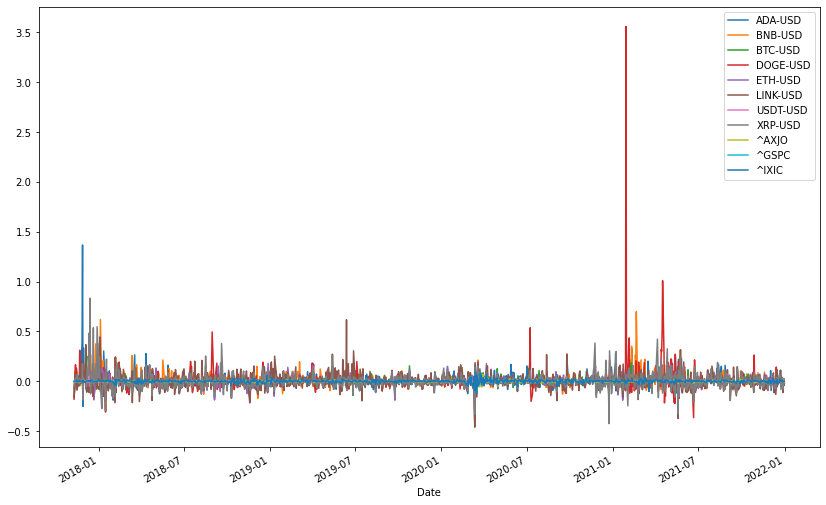

In [90]:
#plot daily returns
combined_df.plot(figsize=(14, 9))

In [91]:
#standard deviation 
combined_df.std()

ADA-USD     0.083679
BNB-USD     0.068861
BTC-USD     0.044561
DOGE-USD    0.134461
ETH-USD     0.055054
LINK-USD    0.078190
USDT-USD    0.005329
XRP-USD     0.077027
^AXJO       0.010872
^GSPC       0.013010
^IXIC       0.014597
dtype: float64

In [92]:
#plot cumulative returns

cum_returns = (1 + combined_df).cumprod() - 1

cum_returns.hvplot(width=1000, height=500)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Rolling Standard Deviation (21 days) for both porfolios'}, xlabel='Date'>

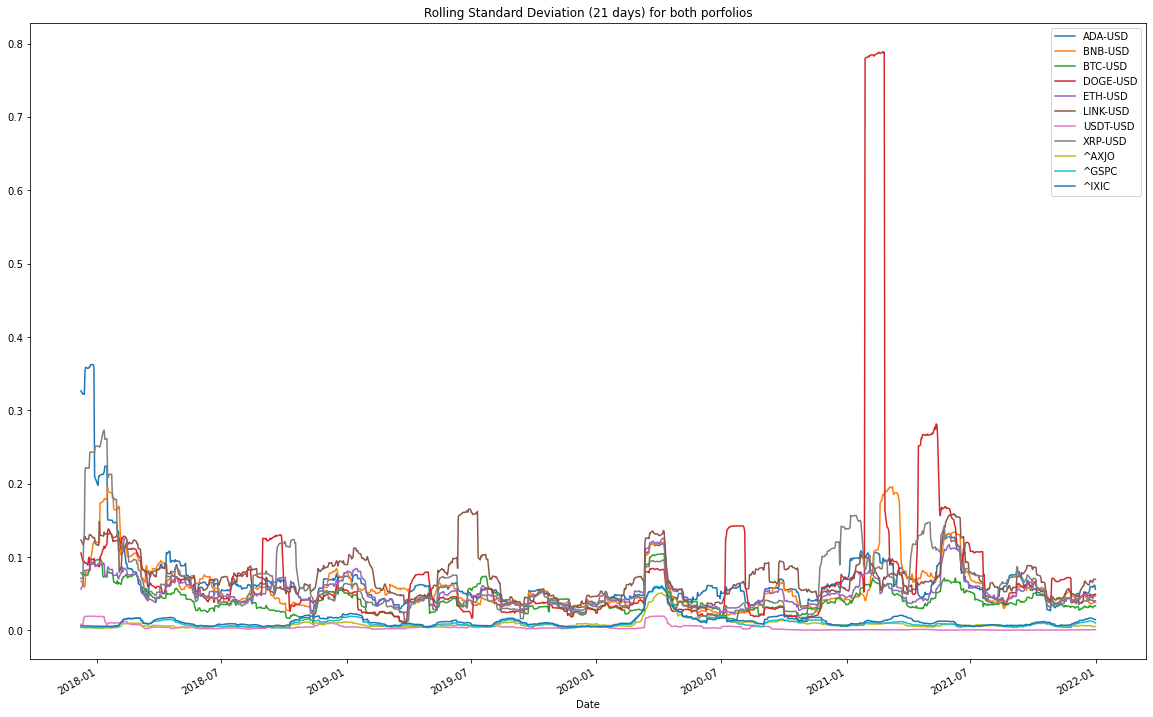

In [93]:
#calculating rolling standard deviation of the combined porfolio
combined_df.rolling(window =21).std().plot(title = "Rolling Standard Deviation (21 days) for both porfolios", figsize=(20, 13))

In [94]:
#correlation
correlation = combined_df.corr()
correlation.style.background_gradient(cmap="winter")

,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,USDT-USD,XRP-USD,^AXJO,^GSPC,^IXIC
ADA-USD,1.000000,0.449237,0.523280,0.271851,0.595987,0.468952,-0.048271,0.621522,0.070873,0.183737,0.184988
BNB-USD,0.449237,1.000000,0.634258,0.222720,0.624040,0.497648,-0.050634,0.446811,0.075115,0.196402,0.208762
BTC-USD,0.523280,0.634258,1.000000,0.331751,0.774027,0.548481,0.022357,0.501500,0.108988,0.224036,0.243006
DOGE-USD,0.271851,0.222720,0.331751,1.000000,0.311440,0.262227,0.006958,0.271644,-0.009802,0.097010,0.090287
ETH-USD,0.595987,0.624040,0.774027,0.311440,1.000000,0.636582,-0.001641,0.618474,0.115929,0.244584,0.259997
LINK-USD,0.468952,0.497648,0.548481,0.262227,0.636582,1.000000,-0.018099,0.474317,0.069842,0.203499,0.215471
USDT-USD,-0.048271,-0.050634,0.022357,0.006958,-0.001641,-0.018099,1.000000,-0.035562,-0.120568,-0.118856,-0.100836
XRP-USD,0.621522,0.446811,0.501500,0.271644,0.618474,0.474317,-0.035562,1.000000,0.046225,0.153037,0.160980
^AXJO,0.070873,0.075115,0.108988,-0.009802,0.115929,0.069842,-0.120568,0.046225,1.000000,0.425834,0.355230
^GSPC,0.183737,0.196402,0.224036,0.097010,0.244584,0.203499,-0.118856,0.153037,0.425834,1.000000,0.945492


In [95]:
#sharpe ratios
sharpe_ratio_stocks = (index_daily_change.mean() *252) / (index_daily_change.std() * np.sqrt(252))
sharpe_ratio_crypto = (crypto_daily_change.mean() *365) / (crypto_daily_change.std() * np.sqrt(365))

stock_pl = px.bar(sharpe_ratio_stocks, title="Stock Market Sharpe Ratios")
crypto_pl =px.bar(sharpe_ratio_crypto, title="Crypto Market Sharpe Ratios" )

In [96]:
tabs = pn.Tabs(
    ("Stock", stock_pl),
    ("Crypto", crypto_pl)
    
    
    
)
tabs

Tabs
    [0] Plotly(Figure, name='Stock')
    [1] Plotly(Figure, name='Crypto')

In [97]:
#Rhoan All USD Crypto Pair Portfolio

In [98]:
# setting up api
cryptowatch_api_key = os.getenv("CRYPTOWATCH_API_KEY")
cw.api_key = cryptowatch_api_key

In [99]:
##Getting historical data

# Set the tickers
markets = ("binance:btcaud")

# This will return a list of 1 day candles, each candle being a list with:
# [close_timestamp, open, high, low, close, volume_base, volume_quote]
candles = cw.markets.get(
    "binance:btcaud",
    ohlc=True
)
daily_candles = candles.of_1d[:-30]
print(json.dumps(daily_candles, indent=4))

[
    [
        1596240000.0,
        15250.0,
        16086.12,
        15199.99,
        15985.33,
        5.693647,
        89869.26097271
    ],
    [
        1596326400.0,
        16030.06,
        16727.03,
        15883.64,
        16641.21,
        13.679593,
        224302.52565097
    ],
    [
        1596412800.0,
        16682.68,
        17073.14,
        15230.44,
        15572.34,
        20.604389,
        327564.11798205
    ],
    [
        1596499200.0,
        15576.84,
        16236.38,
        15576.84,
        15901.75,
        19.635283,
        311281.16150978
    ],
    [
        1596585600.0,
        15901.75,
        16139.98,
        15630.39,
        15703.31,
        11.078404,
        175538.07974448
    ],
    [
        1596672000.0,
        15719.34,
        16523.46,
        15611.82,
        16299.96,
        17.394859,
        277782.88669345
    ],
    [
        1596758400.0,
        16482.59,
        17088.88,
        16203.25,
        16361.56,
 

In [100]:
# find the price and date of the btc
btc_value = daily_candles[0][4]
btc_date = daily_candles[0][0]
print(btc_date)
print(btc_value)

1596240000.0
15985.33


In [101]:
#Get a list of the btc closing price
btc_closing_price = np.array(daily_candles)
#Get a list of the btc closing price
btc_closing_price_date = np.array(daily_candles)

In [102]:
#convert arrays into pandas dataframes
df_btc = pd.DataFrame(btc_closing_price)
df_btc = df_btc.set_axis(["Date","Open","High","Low","Close","Volume_base","Volume_quote"], axis=1, inplace=False)
df_btc["Date"] = pd.to_datetime(df_btc["Date"],unit="s")
df_btc.set_index("Date", inplace=True)
df_btc.head(1)

,Open,High,Low,Close,Volume_base,Volume_quote
Date,,,,,,
2020-08-01,15250.0,16086.12,15199.99,15985.33,5.693647,89869.260973


In [103]:
# Created a shifted column to calculate difference between each data entry in close
df_btc['shifted_column'] = df_btc["Close"].shift(1)

# Calculate the difference between each data entry
df_btc["Difference"] = df_btc["Close"] - df_btc["shifted_column"]

#Calculate the percentage change from 'close' (the 'shifted_column' is the correct answer)
df_btc["BTC"] = df_btc["Difference"] / df_btc["shifted_column"]

#drop the unused columns
df_btc.drop(["shifted_column", "Close", "Difference", "Open","High", "Low", "Volume_base", "Volume_quote"], axis=1, inplace=True)

In [104]:
df_btc.head()

,BTC
Date,
2020-08-01,NaN
2020-08-02,0.041030
2020-08-03,-0.064230
2020-08-04,0.021154
2020-08-05,-0.012479


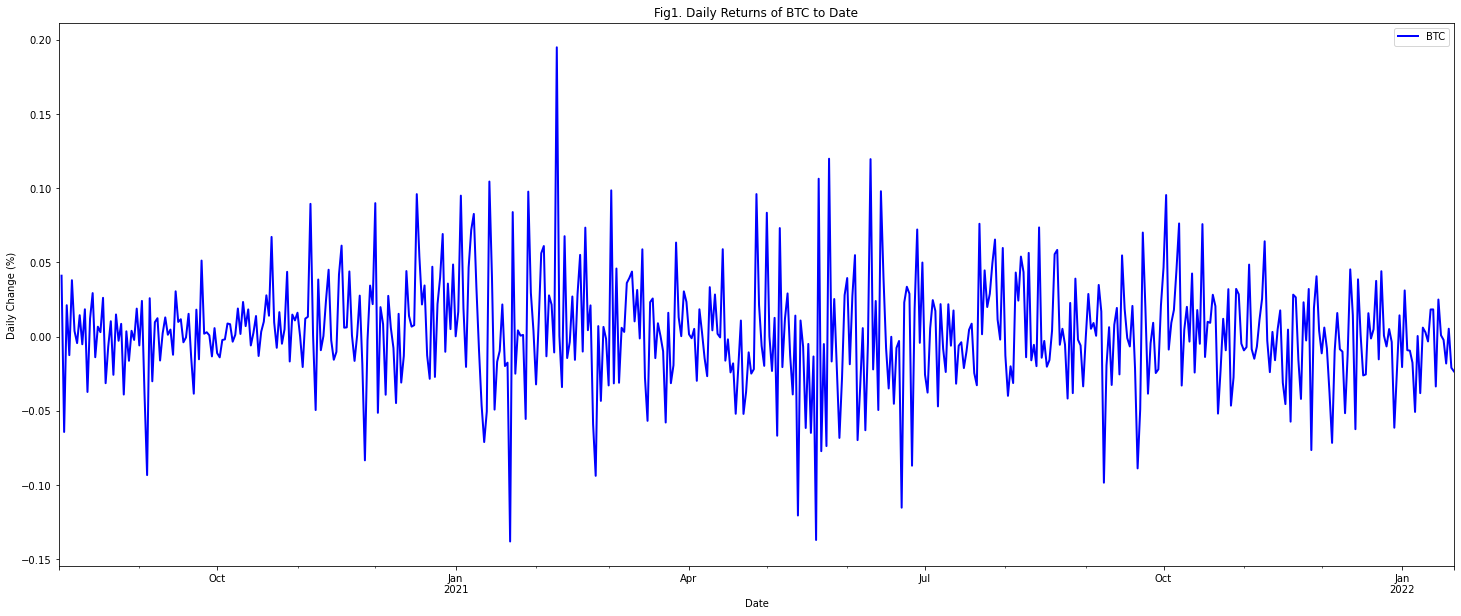

In [105]:
#Calculate and plot daily returns of btc portfolio
daily_returns = df_btc
dr = daily_returns.plot(lw=2,figsize=(25,10), colormap="winter", markersize=10, title="Fig1. Daily Returns of BTC to Date", ylabel="Daily Change (%)", xlabel="Date")

<AxesSubplot:title={'center':'Fig2. Daily Cumulative Returns of BTC to date'}, xlabel='Date', ylabel='Daily Return (%)'>

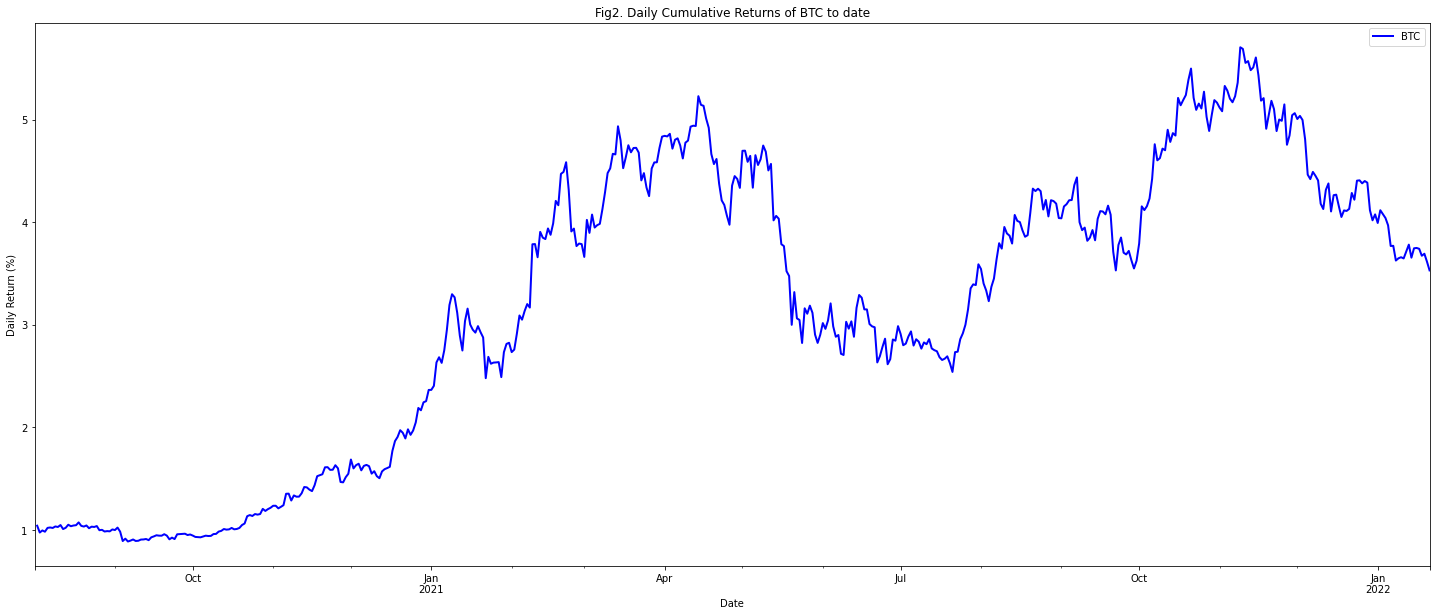

In [106]:
# Calculate and plot cumulative returns for all portfolios. Does any portfolio outperform BTC?
df_cum = (1+ daily_returns).cumprod()
df_cum.plot(lw=2,figsize=(25,10), colormap="winter", markersize=10, title="Fig2. Daily Cumulative Returns of BTC to date", ylabel="Daily Return (%)", xlabel="Date")

<AxesSubplot:title={'center':'Fig3. Daily Returns Box Plot'}, ylabel='% Change'>

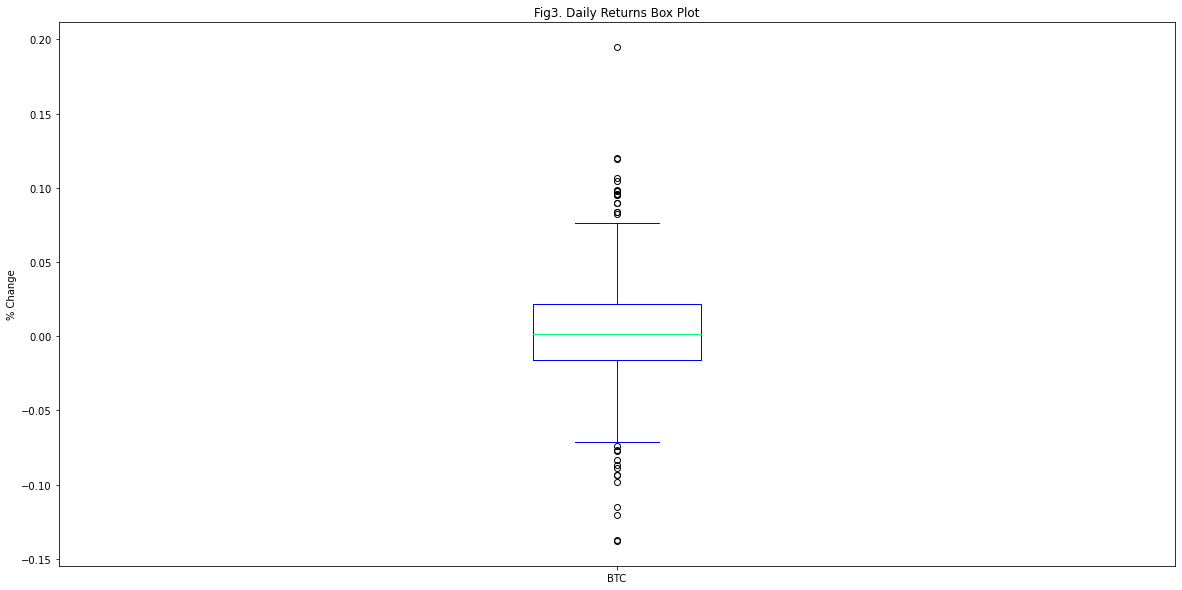

In [107]:
# Create a box plot for each of the returns.
daily_returns.plot(kind = "box", colormap="winter", figsize = (20,10), ylabel="% Change", title="Fig3. Daily Returns Box Plot")

In [108]:
# Daily Standard Deviations
# Calculate the standard deviation for each portfolio.
df_daily_std = pd.DataFrame(daily_returns.std()).rename(columns = {0:"std"})
df_daily_std

,std
BTC,0.037482


In [109]:
cw.exchanges.list()

<ExchangeListAPIResponse([<Exchange(Poloniex)>, <Exchange(Binance)>, <Exchange(DEX (aggregated))>, <Exchange(Zonda)>, <Exchange(HitBTC)>, <Exchange(Bitfinex)>, <Exchange(Coinbase Pro)>, <Exchange(Kraken)>, <Exchange(Bisq)>, <Exchange(Kraken Futures)>, <Exchange(CME (Beta))>, <Exchange(Uniswap V2)>, <Exchange(WEX)>, <Exchange(meXBT)>, <Exchange(Huobi)>, <Exchange(Vault of Satoshi)>, <Exchange(Luno)>, <Exchange(Bithumb)>, <Exchange(OKX)>, <Exchange(Gate.io)>, <Exchange(Quoine)>, <Exchange(796)>, <Exchange(BTC China)>, <Exchange(Bitstamp)>, <Exchange(CEX.IO)>, <Exchange(Bittrex)>, <Exchange(Coinone)>, <Exchange(Bit-Z)>, <Exchange(Binance.US)>, <Exchange(COMEX (Beta))>, <Exchange(Liquid)>, <Exchange(OKCoin)>, <Exchange(BitMEX)>, <Exchange(NYMEX (Beta))>, <Exchange(CBOT)>, <Exchange(Cryptsy)>, <Exchange(bitFlyer)>, <Exchange(Deribit)>, <Exchange(QuadrigaCX)>, <Exchange(FTX)>, <Exchange(FTX.US)>, <Exchange(Gemini)>, <Exchange(BitVC)>, <Exchange(Mt. Gox)>])>

In [110]:
 print(cw.__version__)
    

0.0.16


In [ ]:
# Get all binance markets
binance = cw.markets.list("binance")
price_dict={}
# For each binance market...
for market in binance.markets:
    
    # Forge current market ticker, like Binance:BTCUSD
    ticker = "{}:{}".format(market.exchange, market.pair).upper()
    #pull only aud pairs
    if market.pair[-3:] == "usd":
        # Request weekly candles for that market
        candles = cw.markets.get(ticker, ohlc=True, periods=["1d"])
        #price_dict[market.pair] = candles.of_1d[-30:]
        
#print(candles.of_1m[:-30])

In [ ]:
#create an individual data frame from the binance usd market
binance_btcaud_df = pd.DataFrame(price_dict["xrptusd"])
binance_btcaud_df.head()

In [ ]:
##df_btc = pd.DataFrame(btc_closing_price)
binance_btcaud_df = binance_btcaud_df.set_axis(["Date","Open","High","Low","Close","Volume_base","Volume_quote"], axis=1, inplace=False)
binance_btcaud_df["Date"] = pd.to_datetime(binance_btcaud_df["Date"],unit="s")
binance_btcaud_df.set_index("Date", inplace=True)
binance_btcaud_df.head()

In [ ]:
#loop through the dictionary and display dataframe with symbol
df_dict={}
returns_df=pd.DataFrame()
for sym in price_dict.keys():
    print('****', sym)
    sub_df = pd.DataFrame(price_dict[sym])
    sub_df = sub_df.set_axis(["Date","Open","High","Low","Close","Volume_base","Volume_quote"], axis=1, inplace=False)
    sub_df["Date"] = pd.to_datetime(sub_df["Date"],unit="s")
    sub_df.set_index("Date", inplace=True)
    sub_df['Returns'] = sub_df['Close'].pct_change()
    display(sub_df.head())
    df_dict[sym] = sub_df
    returns_df[sym] = sub_df['Returns']

In [ ]:
returns_df.describe

In [ ]:
returns_df.head()

In [ ]:
returns_df["USD Pairs"] = returns_df.mean(axis=1)
returns_df.drop(returns_df.columns.difference(["USD Pairs","btctusd"]), 1, inplace=True)
returns_df.head()

In [ ]:
#Plot daily returns of portfolio_usd
daily_returns = returns_df
daily_returns.plot(lw=2,figsize=(25,10), colormap="winter", markersize=10, title="Fig1. Daily Returns of All USD Pairs", ylabel="Daily Change (%)", xlabel="Date")

In [ ]:
#Calculate and plot cumalative returns
df_cum = (1+ daily_returns).cumprod()
df_cum.plot(lw=2,figsize=(25,10), colormap="winter", markersize=10, title="Fig2. Daily Cumulative Returns of All USD Pairs", ylabel="Daily Return (%)", xlabel="Date")

In [ ]:
# Create a box plot for each of the returns.
daily_returns.plot(kind = "box", colormap="winter", figsize = (20,10), ylabel="% Change", title="Fig3. Daily Returns Box Plot")

In [ ]:
# Daily Standard Deviations
# Calculate the standard deviation for each portfolio.
df_daily_std = pd.DataFrame(daily_returns.std()).rename(columns = {0:"std"})
df_daily_std

In [136]:
#Comparative Analysis of all Portfolios

In [174]:
luke_df = dat.xs('daily_return',level=1,axis=1)
luke_df.head()

,DJP,GLD,IEF,SPY,TLT
time,,,,,
2018-01-10 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN
2018-01-11 00:00:00-05:00,0.000817,NaN,0.000765,NaN,0.004120
2018-01-12 00:00:00-05:00,0.008568,NaN,-0.000860,NaN,0.001850
2018-01-16 00:00:00-05:00,-0.006068,0.001536,0.000478,-0.003418,0.004015
2018-01-17 00:00:00-05:00,0.004070,-0.008099,-0.002103,0.009568,-0.001120


In [175]:
luke_df.columns = luke_df.columns.map(''.join)
luke_df.head()

,DJP,GLD,IEF,SPY,TLT
time,,,,,
2018-01-10 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN
2018-01-11 00:00:00-05:00,0.000817,NaN,0.000765,NaN,0.004120
2018-01-12 00:00:00-05:00,0.008568,NaN,-0.000860,NaN,0.001850
2018-01-16 00:00:00-05:00,-0.006068,0.001536,0.000478,-0.003418,0.004015
2018-01-17 00:00:00-05:00,0.004070,-0.008099,-0.002103,0.009568,-0.001120


In [146]:
combined_df
combined_dfined_df["Gaetano Portfolio"] = combined_df.mean(axis=1)

,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,USDT-USD,XRP-USD,^AXJO,^GSPC,^IXIC
Date,,,,,,,,,,,
2017-11-10,-0.153933,-0.097415,-0.073554,-0.178092,-0.067411,-0.162375,-0.002152,-0.050600,-0.003306,-0.000898,0.000132
2017-11-13,0.076365,0.109845,0.102422,0.166667,0.028606,0.071230,-0.003082,0.030927,-0.001261,0.000984,0.000987
2017-11-14,0.016352,-0.055757,0.011626,-0.022296,0.066037,0.027547,-0.002497,0.031375,-0.009266,-0.002310,-0.002920
2017-11-15,0.008197,-0.039012,0.102444,0.130912,-0.012659,-0.010504,-0.003625,0.014922,-0.005330,-0.005526,-0.004699
2017-11-16,0.042919,0.031017,0.076023,0.038088,-0.007298,-0.087983,-0.001057,0.066450,0.001567,0.008196,0.012985
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.039056,0.028604,-0.003328,-0.012183,-0.007322,-0.001203,-0.000505,0.005432,0.000000,0.013839,0.013920
2021-12-28,-0.073136,-0.049256,-0.060259,-0.072390,-0.058613,-0.112722,0.001224,-0.079060,0.000000,-0.001010,-0.005642
2021-12-29,-0.050953,-0.039122,-0.024042,-0.036481,-0.045348,-0.033769,-0.000873,-0.042494,0.012062,0.001402,-0.000982


In [140]:
df_btc.head()

,BTC
Date,
2020-08-01,NaN
2020-08-02,0.041030
2020-08-03,-0.064230
2020-08-04,0.021154
2020-08-05,-0.012479


In [ ]:
# compile the list of dataframes you want to merge
data_frames_custom = [otex_returns_csv, l_returns_csv, shop_returns_csv]
df_custom = reduce(lambda  left,right: pd.merge(left,right,on=["Date"],
                                            how='inner'), data_frames_custom)
df_custom.head()